# Quick Start Guide

<br>

This notebook outlines how to get up and running with the `ElexonDataPortal` library, a Python client for retrieving data from the Elexon/BMRS API.

The core functionality is exposed through the `ElexonDataPortal.api` module which we'll now import.

<br>

### Client Initialisation

We're now ready to initialise the API `Client`. The key parameter to pass is the `api_key`, alternatively this can be set as the environment variable `BMRS_API_KEY` which will then be loaded automatically (as in this example).

In [1]:
#hide
# loads the api_key into an environment variable - delete this cell if passing as string
import os
from dotenv import load_dotenv

assert load_dotenv('../.env'), 'Environment variables could not be loaded'
api_key = os.environ['BMRS_API_KEY']

<br>

We then just need to import the `api` module and initialise the `Client` class

In [2]:
from ElexonDataPortal import api

client = api.Client() # or use `api.Client('your_api_key_here')`

client

<br>

### Client Usage

The client exposes a `methods` attribute which provides a quick way to explore what request methods are available alongside a short description of the data they return.

In [3]:
import pandas as pd

pd.Series(client.methods).head()

get_B0610                  Actual Total Load per Bidding Zone
get_B0620      Day-Ahead Total Load Forecast per Bidding Zone
get_B0630     Week-Ahead Total Load Forecast per Bidding Zone
get_B0640    Month-Ahead Total Load Forecast Per Bidding Zone
get_B0650     Year Ahead Total Load Forecast per Bidding Zone
dtype: object

<br>

Lets look at the docstring for a specific method, in this case the B1610 stream.

In [4]:
print(client.get_B1610.__doc__)


        Actual Generation Output per Generation Unit
        
        Parameters:
            start_date (str)
            end_date (str)
            NGCBMUnitID (str)
        


<br>

Now we know what to pass in to the `get_B1610` method lets call it! 

Each response (4 in this example) will be automatically cleaned and parsed, then concatenated into a single Pandas DataFrame.

In [5]:
start_date = '2020-01-01'
end_date = '2020-01-01 1:30'

df_B1610 = client.get_B1610(start_date, end_date)

df_B1610.head(3)

B1610: 100%|██████████████████████████████████████| 3/3 [00:04<00:00,  1.53s/it]


,local_datetime,documentType,businessType,processType,timeSeriesID,curveType,settlementDate,powerSystemResourceType,registeredResourceEICCode,marketGenerationUnitEICCode,...,bMUnitID,nGCBMUnitID,activeFlag,documentID,documentRevNum,resolution,start,end,settlementPeriod,quantity
0,2020-01-01 00:00:00+00:00,Actual generation,Production,Realised,ELX-EMFIP-AGOG-TS-287,Sequential fixed size block,2020-01-01,Generation,48W00000GRIFW-2Y,48W00000GRIFW-2Y,...,T_GRIFW-2,GRIFW-2,Y,ELX-EMFIP-AGOG-22495386,1,PT30M,2020-01-01,2020-01-01,1,12.48
1,2020-01-01 00:00:00+00:00,Actual generation,Production,Realised,ELX-EMFIP-AGOG-TS-289,Sequential fixed size block,2020-01-01,Generation,48W0000GYMRO-15O,48W0000GYMRO-15O,...,T_GYMR-15,GYMRO-15,Y,ELX-EMFIP-AGOG-22495386,1,PT30M,2020-01-01,2020-01-01,1,19.1
2,2020-01-01 00:00:00+00:00,Actual generation,Production,Realised,ELX-EMFIP-AGOG-TS-307,Sequential fixed size block,2020-01-01,Generation,48W000000HRTL-24,48W000000HRTL-24,...,T_HRTL-2,HRTL-2,Y,ELX-EMFIP-AGOG-22495386,1,PT30M,2020-01-01,2020-01-01,1,594.696


<br>

We could see from the docstring that there were more parameters we could specify, lets pass in the `NGCBMUnitID` and look at the output for a single power plant. In this example we'll look at the power output from *'LARYO-1'*, which makes up roughly 1/4 of the London Array wind farm.

B1610: 100%|████████████████████████████████████| 95/95 [00:32<00:00,  2.90it/s]


<AxesSubplot:xlabel='local_datetime'>

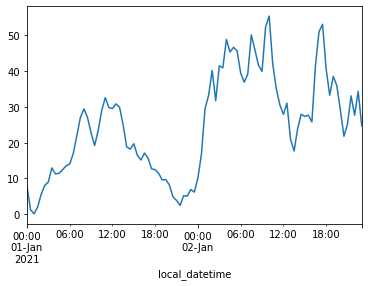

In [6]:
start_date = '2021-01-01'
end_date = '2021-01-02 23:30'
NGCBMUnitID = 'LARYO-1'

df_LARYO_1 = client.get_B1610(start_date, end_date, NGCBMUnitID)

df_LARYO_1.set_index('local_datetime')['quantity'].astype(float).plot()

<br>

Before moving on we'll quickly show what an alternative data stream might return, in this case the `B1440` stream which provides *'Generation forecasts for Wind and Solar'*.

In [7]:
start_date = '2020-01-01'
end_date = '2020-01-01 1:30'

df_B1440 = client.get_B1440(start_date, end_date)

df_B1440.head(3)

B1440: 100%|██████████████████████████████████████| 3/3 [00:01<00:00,  2.97it/s]


,local_datetime,timeSeriesID,businessType,powerSystemResourceType,settlementDate,processType,settlementPeriod,quantity,documentType,curveType,resolution,activeFlag,documentID,documentRevNum
0,2020-01-01 00:00:00+00:00,NGET-EMFIP-DGWS-TS-00034592,Solar generation,"""Solar""",2020-01-01,Day Ahead,1,0,Wind and solar forecast,Sequential fixed size block,PT30M,Y,NGET-EMFIP-DGWS-00035923,1
1,2020-01-01 00:00:00+00:00,NGET-EMFIP-DGWS-TS-00034590,Wind generation,"""Wind Offshore""",2020-01-01,Day Ahead,1,2843.181,Wind and solar forecast,Sequential fixed size block,PT30M,Y,NGET-EMFIP-DGWS-00035923,1
2,2020-01-01 00:00:00+00:00,NGET-EMFIP-DGWS-TS-00034591,Wind generation,"""Wind Onshore""",2020-01-01,Day Ahead,1,3024.238,Wind and solar forecast,Sequential fixed size block,PT30M,Y,NGET-EMFIP-DGWS-00035923,1


<br>

### Date Handling

Often a main pain point when working with time-series data is having to handle timezones, this is made more complex when working with data from the power sector as the datetime is expressed through a combination of settlement dates and settlement periods (half-hour trading blocks). `ElexonDataPortal` has a utility function for determining the settlement dates and periods over a specified date range.

In [8]:
from ElexonDataPortal.dev import utils

start_date = '2021-01-01'
end_date = '2021-01-02'

df_dates_SPs = utils.dt_rng_to_SPs(start_date, end_date)

df_dates_SPs.head()

,date,SP
2021-01-01 00:00:00+00:00,2021-01-01,1
2021-01-01 00:30:00+00:00,2021-01-01,2
2021-01-01 01:00:00+00:00,2021-01-01,3
2021-01-01 01:30:00+00:00,2021-01-01,4
2021-01-01 02:00:00+00:00,2021-01-01,5


<br>

This is then used by the client to determine the correct settlement period and date pairs to request, as well as how to then parse the returned data and create a new column containing the local datetime. In this example we'll look at what happens when the clocks change forwards (there will be 46 SPs on this date).

In [9]:
start_date = '2020-03-28 23:00'
end_date = '2020-03-29 02:30'

df_B1610_clock_change = client.get_B1610(start_date, end_date)

df_B1610_clock_change[['local_datetime', 'settlementDate', 'settlementPeriod']].drop_duplicates()

B1610: 100%|██████████████████████████████████████| 5/5 [00:06<00:00,  1.22s/it]


,local_datetime,settlementDate,settlementPeriod
0,2020-03-28 23:00:00+00:00,2020-03-28,47
159,2020-03-28 23:30:00+00:00,2020-03-28,48
318,2020-03-29 00:00:00+00:00,2020-03-29,1
478,2020-03-29 00:30:00+00:00,2020-03-29,2
639,2020-03-29 02:00:00+01:00,2020-03-29,3


<br>

In this example we'll look at what happens when the clocks change backwards (there will be 50 SPs on this date).

In [10]:
start_date = '2020-10-25 00:30'
end_date = '2020-10-25 02:00'

df_B1610_clock_change = client.get_B1610(start_date, end_date)

df_B1610_clock_change[['local_datetime', 'settlementDate', 'settlementPeriod']].drop_duplicates()

B1610: 100%|██████████████████████████████████████| 5/5 [00:06<00:00,  1.22s/it]


,local_datetime,settlementDate,settlementPeriod
0,2020-10-25 00:30:00+01:00,2020-10-25,2
155,2020-10-25 01:00:00+01:00,2020-10-25,3
305,2020-10-25 01:30:00+01:00,2020-10-25,4
451,2020-10-25 01:00:00+00:00,2020-10-25,5
592,2020-10-25 01:30:00+00:00,2020-10-25,6


<br>

Sometimes we want to do away with local datetimes all together and just use UTC or even another timezone altogether, to achieve this we can use the `non_local_tz` parameter when initialising the `Client` class.

N.b. as part of this change the `local_datetime` column is renamed to simply `datetime`.

In [12]:
start_date = '2020-10-25 00:30'
end_date = '2020-10-25 02:00'

client = api.Client(non_local_tz='UTC')

df_B1610_clock_change = client.get_B1610(start_date, end_date)

df_B1610_clock_change[['datetime', 'settlementDate', 'settlementPeriod']].drop_duplicates()

B1610: 100%|██████████████████████████████████████| 5/5 [00:05<00:00,  1.06s/it]


,datetime,settlementDate,settlementPeriod
0,2020-10-24 23:30:00+00:00,2020-10-25,2
155,2020-10-25 00:00:00+00:00,2020-10-25,3
305,2020-10-25 00:30:00+00:00,2020-10-25,4
451,2020-10-25 01:00:00+00:00,2020-10-25,5
592,2020-10-25 01:30:00+00:00,2020-10-25,6


<br>

### Under the Hood

If you've previously written your own code for extracting data from the Elexon/BMRS API then you may be wondering where some of the normal parameters you pass have gone. The differences in the parameters passed are due to 4 core drivers:

* Standardisation of date range parameter names
* Removal of the need to specify `ServiceType`
* Automatic passing of `APIKey` after client initialisation
* Shipped with sensible defaults for all remaining parameters

If you wish to make requests using the raw methods these are available through the `ElexonDataportal.dev.raw` module. We'll quickly make one of these requests, note that in this example we'll specify `ServiceType=csv`.

In [8]:
import io
from ElexonDataPortal import dev

r = dev.raw.get_B1610(
    APIKey=api_key,
    SettlementDate='2020-01-01',
    Period='1',
    NGCBMUnitID='*',
    ServiceType='csv',
)

df_B1610_raw_csv = pd.read_csv(io.StringIO(r.content.decode('utf-8')), skiprows=1)

df_B1610_raw_csv.head(3)

,Time Series ID,Registered Resource EIC Code,BM Unit ID,NGC BM Unit ID,PSR Type,Market Generation Unit EIC Code,Market Generation BMU ID,Market Generation NGC BM Unit ID,Settlement Date,SP,Quantity (MW)
0,ELX-EMFIP-AGOG-TS-319,48W00000LNCSO-1R,T_LNCSW-1,LNCSO-1,Generation,48W00000LNCSO-1R,T_LNCSW-1,LNCSO-1,2020-01-01,1,56.076
1,ELX-EMFIP-AGOG-TS-320,48W00000LNCSO-2P,T_LNCSW-2,LNCSO-2,Generation,48W00000LNCSO-2P,T_LNCSW-2,LNCSO-2,2020-01-01,1,47.456
2,ELX-EMFIP-AGOG-TS-175,48W00000CLDRW-16,E_CLDRW-1,CLDRW-1,Generation,48W00000CLDRW-16,E_CLDRW-1,CLDRW-1,2020-01-01,1,3.096


<br>

If you wish to use `ServiceType=xml` you can use the `ElexonDataPortal.dev.utils.parse_xml_response` function to convert the response into a Pandas DataFrame.

In [9]:
r = dev.raw.get_B1610(
    APIKey=api_key,
    SettlementDate='2020-01-01',
    Period='1',
    NGCBMUnitID='*',
    ServiceType='xml',
)

df_B1610_raw_xml = dev.utils.parse_xml_response(r)

df_B1610_raw_xml.head(3)

,documentType,businessType,processType,timeSeriesID,curveType,settlementDate,powerSystemResourceType,registeredResourceEICCode,marketGenerationUnitEICCode,marketGenerationBMUId,...,bMUnitID,nGCBMUnitID,activeFlag,documentID,documentRevNum,resolution,start,end,settlementPeriod,quantity
0,Actual generation,Production,Realised,ELX-EMFIP-AGOG-TS-236,Sequential fixed size block,2020-01-01,Generation,48W00000CLDCW-17,48W00000CLDCW-17,T_CLDCW-1,...,T_CLDCW-1,CLDCW-1,Y,ELX-EMFIP-AGOG-22495386,1,PT30M,2020-01-01,2020-01-01,1,96.42
1,Actual generation,Production,Realised,ELX-EMFIP-AGOG-TS-171,Sequential fixed size block,2020-01-01,Generation,48W00000BRYBW-10,48W00000BRYBW-10,E_BRYBW-1,...,E_BRYBW-1,BRYBW-1,Y,ELX-EMFIP-AGOG-22495386,1,PT30M,2020-01-01,2020-01-01,1,46.42
2,Actual generation,Production,Realised,ELX-EMFIP-AGOG-TS-257,Sequential fixed size block,2020-01-01,Generation,48W000000EECL-15,48W000000EECL-15,T_EECL-1,...,T_EECL-1,EECL-1,Y,ELX-EMFIP-AGOG-22495386,1,PT30M,2020-01-01,2020-01-01,1,232.272


<br>

But how do we go from these raw methods to the standardised client that we first saw?

The glue that enables this is the `ElexonDataPortal.dev.orchestrator.query_orchestrator` function which provides a wrapper for the various request types. Crucially, the `query_orchestrator` provides a mechanism for collating requests over a date range with the different request types broken down into:

* SP_and_date
* date_range
* date_time_range
* year
* year_and_month
* year_and_week
* non_temporal

Let's make a request to the same BMRS stream using the orchestrator.

In [10]:
start_date = '2020-01-01'
end_date = '2020-01-01'

df_B1610_orchestrator = dev.orchestrator.query_orchestrator(
    api_key=api_key,
    start_date=start_date,
    end_date=end_date,
    method='get_B1610',
    request_type='SP_and_date',
    kwargs_map={'date': 'SettlementDate', 'SP': 'Period'},
    func_params=['APIKey', 'date', 'SP', 'ServiceType'],
)

df_B1610_orchestrator.head(3)

B1610: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.11s/it]


,local_datetime,documentType,businessType,processType,timeSeriesID,curveType,settlementDate,powerSystemResourceType,registeredResourceEICCode,marketGenerationUnitEICCode,...,bMUnitID,nGCBMUnitID,activeFlag,documentID,documentRevNum,resolution,start,end,settlementPeriod,quantity
0,2020-01-01 00:00:00+00:00,Actual generation,Production,Realised,ELX-EMFIP-AGOG-TS-361,Sequential fixed size block,2020-01-01,Generation,48W00000WBURB-27,48W00000WBURB-27,...,T_WBURB-2,WBURB-2,Y,ELX-EMFIP-AGOG-22495386,1,PT30M,2020-01-01,2020-01-01,1,275.38
1,2020-01-01 00:00:00+00:00,Actual generation,Production,Realised,ELX-EMFIP-AGOG-TS-233,Sequential fixed size block,2020-01-01,Generation,48W000000BLLA-2I,48W000000BLLA-2I,...,T_BLLA-2,BLLA-2,Y,ELX-EMFIP-AGOG-22495386,1,PT30M,2020-01-01,2020-01-01,1,8.194
2,2020-01-01 00:00:00+00:00,Actual generation,Production,Realised,ELX-EMFIP-AGOG-TS-326,Sequential fixed size block,2020-01-01,Generation,48W000000NANT-1R,48W000000NANT-1R,...,T_NANT-1,NANT-1,Y,ELX-EMFIP-AGOG-22495386,1,PT30M,2020-01-01,2020-01-01,1,12.75


<br>

It's worth noting that there are some differences in the returned DataFrames. Firstly, when specifying `ServiceType=csv` the number of columns is much smaller as the data that is nested within the xml representation is simply not included. Secondly, the orchestrator response includes an additional column relative to the xml one even though it itself specifies `ServiceType=xml`, this is because the orchestrator introduces a new column containing the local datetime as Pandas Timestamps.

In [11]:
(
    df_B1610_raw_csv.columns.size, 
    df_B1610_raw_xml.columns.size, 
    df_B1610_orchestrator.columns.size
)

(11, 21, 22)

<br>

The response from the `ElexonDataPortal.api.Client` is the same as that returned by the orchestrator.

In [12]:
(df_B1610.columns == df_B1610_orchestrator.columns).mean() == 1

True